# Choose Run

In [1]:
# Check params
user_name = 'P4'
run_name = '20250923' 
output_path = f'./data/plots/{run_name}'

# INIT

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
from pyscript_data import *
from plotting import *


# Setting

In [ ]:
bounds=np.array([[50, 1750], [0, 800], [5, 50]])
movement_direction = 'both'
size = bounds[:,1] - bounds[:,0]
ycenter = size[1]/2 + bounds[1,0]
numx = 6
numr = 3
max_counts_per_target = 5
num_targets = numx*numr
target_ids = [i for i in range(num_targets)]
target_count = np.zeros((num_targets,))
targetr = bounds[2][0] + np.linspace(5, bounds[2][1]-bounds[2][0], numr)
if movement_direction == 'right':
    start_target = np.array([3.0,0,3.0])
    targetx =  np.linspace(bounds[0][0]+200, bounds[0][1]-bounds[2][1], numx)
elif movement_direction == 'left':
    start_target = np.array([bounds[0][1] - 3.0,0,3.0])
    targetx = np.linspace(bounds[0][0] - bounds[2][1], bounds[0][1]-200, numx)
else:
    assert numx % 2 == 0
    center = (bounds[0][0]+bounds[0][1])//2
    distance_from_center = np.linspace((bounds[0][0]+bounds[0][1])//8, (bounds[0][0]+bounds[0][1])//2 - bounds[2,1], numx//2)
    start_target = np.array([center,0,3.0])
    targets_right = center + distance_from_center
    targets_left = center - distance_from_center
    targetx = np.hstack([targets_left, targets_right])
    
targetsxr = np.meshgrid(targetx, targetr)
targetsxr = np.stack((targetsxr[0],targetsxr[1]), axis=-1).reshape(num_targets,2).tolist()
targets = np.array([np.array((xr[0],0.0,xr[1])) for xr in targetsxr])
trial = False

# Scaling for AIF, remove y
start_target = start_target/1000
targets = targets/1000

start_target = np.array([start_target[0], start_target[2]])
targets = np.array([[t[0], t[2]] for t in targets])

# Sort width and distance, descending
targets = targets[np.lexsort((-targets[:, 0], -targets[:, 1]))]

numreps = 10

target_IDs = np.array([np.log2(target[1]/target[0]+1) for target in targets])

In [5]:
targets

array([[1.75  , 0.05  ],
       [1.4375, 0.05  ],
       [1.125 , 0.05  ],
       [0.675 , 0.05  ],
       [0.3625, 0.05  ],
       [0.05  , 0.05  ],
       [1.75  , 0.03  ],
       [1.4375, 0.03  ],
       [1.125 , 0.03  ],
       [0.675 , 0.03  ],
       [0.3625, 0.03  ],
       [0.05  , 0.03  ],
       [1.75  , 0.01  ],
       [1.4375, 0.01  ],
       [1.125 , 0.01  ],
       [0.675 , 0.01  ],
       [0.3625, 0.01  ],
       [0.05  , 0.01  ]])

# Complete Plots

## Load Data

### Load Simulation

In [6]:
numreps = 1

complete_data = {}
for targetid in range(num_targets):
    files = [f'./data/sim_data/{run_name}/target_{targetid}_rep_{i}.pickle' for i in range(numreps)]
    for j, file in enumerate(files):
        # Check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist.")
        # read data
        else:
            with open(file, 'rb') as f:
                data = pickle.load(f)
                print(f"Data loaded from {file}.")
            complete_data[(targetid, j)] = data

# Get time step length
dt = complete_data[(0, 0)]['dt']


Data loaded from ./data/sim_data/20250923/target_0_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_1_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_2_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_3_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_4_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_5_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_6_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_7_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_8_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_9_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_10_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_11_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_12_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_13_rep_0.pickle.
Data loaded from ./data/sim_data/20250923/target_14_rep_0.pickle.
Data loaded from ./d

In [7]:
# Get all pos vel data
sim_pos = {}
sim_vel = {}
sim_pos_total = []
sim_vel_total = []
for targetid in range(num_targets):   
    for repeat in range(numreps):
        if (targetid, repeat) not in complete_data:
            print(f"Data for target {targetid}, repeat {repeat} not found.")
            continue
        data = complete_data[(targetid, repeat)]
        xx = data['xx']
        pos = [x[0]*1000+900 for x in xx]
        vel = [x[1]*1000*dt for x in xx]

        sim_pos[(targetid,repeat)] = np.array(pos)
        sim_vel[(targetid,repeat)] = np.array(vel)
        sim_pos_total.extend(pos)
        sim_vel_total.extend(vel)

sim_pos_total = np.array(sim_pos_total)
sim_vel_total = np.array(sim_vel_total)


In [8]:
# Endpoint variance
endpoints = {}
for (targetid, i) in sim_pos.keys():
    if targetid not in endpoints:
        endpoints[targetid] = []
    endpoints[targetid].append(sim_pos[(targetid, i)][-1])
endpoint_means_sim = {}
endpoint_stds_sim = {}
for targetid in range(num_targets):
    endpoint_means_sim[targetid] = np.mean(endpoints[targetid])
    endpoint_stds_sim[targetid] = np.std(endpoints[targetid])

endpoints_w50 = []
endpoints_w30 = []
endpoints_w10 = []
for targetid in range(num_targets):
    if targets[targetid][1] == 0.05:
        endpoints_w50.append(endpoint_stds_sim[targetid])
    elif targets[targetid][1] == 0.03:
        endpoints_w30.append(endpoint_stds_sim[targetid])
    elif targets[targetid][1] == 0.01:
        endpoints_w10.append(endpoint_stds_sim[targetid])

print(f"{np.mean(endpoints_w50):.2f}")

print(f"{np.mean(endpoints_w30):.2f}")

print(f"{np.mean(endpoints_w10):.2f}")

0.00
0.00
0.00


### Load User Data

In [9]:
# Get user data
user_data_path = f"./data/user_data/{user_name}_log_10.json"
user_pos = {}
user_vel = {}
user_pos_total = []
user_vel_total = []
clicks_complete = {}
for targetid in range(num_targets):        
    # Prepare user data
    trial_data, total_clicks, trial_data_interp = get_trials_for_target_id_from_json(user_data_path, target_id=targetid, dt=dt)
    
    user_pos_id = []
    user_vel_id = []

    # Extract user data
    for i in range(len(trial_data)):
        user_data = trial_data[i]
        user_pos_id.extend(user_data['x'].to_list())
        user_vel_id.extend(user_data['x_vel'].to_list())
        user_pos[(targetid,i)] = np.array(user_data['x'])
        user_vel[(targetid,i)] = np.array(user_data['x_vel'])
    user_pos_total.extend(user_pos_id)
    user_vel_total.extend(user_vel_id)

    clicks_complete[targetid] = total_clicks
user_pos_total = np.array(user_pos_total)
user_vel_total = np.array(user_vel_total)


In [10]:
# Setup trial data
trialdata = pd.DataFrame(complete_data.keys(), columns=['targetid', 'rep'])

# Setup target data
targetdata = pd.DataFrame(targets, columns=['x', 'r'])
targetdata['targetid'] = targetdata.index
targetdata["width"] = 2*targetdata.loc[:,'r'].values * 1000
targetdata["distance"] =  np.abs(targetdata.loc[:,'x'].values*1000 - 900.0)
targetdata["ID"] = np.log2(targetdata["distance"] /targetdata["width"] + 1)

# add target data to trialdata
trialdata = trialdata.merge(targetdata, on='targetid')

# Add movement time to trial data
trialdata['movement_time'] = [len(data['xx']) * dt for (targetid, i), data in complete_data.items()]

In [11]:
# Get mean and std movement time per unique ID
unique_IDs = trialdata['ID'].unique()
mean_movement_times = {}
std_movement_times = {}
for id in unique_IDs:
    mean_mt = trialdata.where(trialdata['ID'] == id).dropna()["movement_time"].mean()
    std_mt = trialdata.where(trialdata['ID'] == id).dropna()["movement_time"].std()
    print(f"ID: {id}, Mean MT: {mean_mt}, Std MT: {std_mt}")
    mean_movement_times[id] = mean_mt
    std_movement_times[id] = std_mt

# Add column for mean and std to target_info
trialdata['mean_movement_time'] = trialdata['ID'].map(mean_movement_times)
trialdata['std_movement_time'] = trialdata['ID'].map(std_movement_times)

# Add column for outlier to target_info
trialdata['outlier'] = ((trialdata['movement_time'] > (trialdata['mean_movement_time'] + 2 * trialdata['std_movement_time'])) | (trialdata['movement_time'] < 0.06))



ID: 3.2479275134435857, Mean MT: 0.56, Std MT: 0.11313708498984763
ID: 2.6724253419714956, Mean MT: 0.47, Std MT: 0.014142135623730925
ID: 1.7004397181410922, Mean MT: 0.36, Std MT: 0.1979898987322333
ID: 3.92283213947754, Mean MT: 0.56, Std MT: 0.02828427124746185
ID: 3.3159043072595926, Mean MT: 0.52, Std MT: 0.05656854249492385
ID: 2.2479275134435857, Mean MT: 0.24, Std MT: 0.02828427124746191
ID: 5.442943495848728, Mean MT: 0.66, Std MT: 0.05656854249492385
ID: 4.800899899920305, Mean MT: 0.5, Std MT: 0.028284271247461926
ID: 3.6147098441152083, Mean MT: 0.63, Std MT: 0.4101219330881976


In [12]:
# Remove outlier from sim_pos and sim_vel
for (targetid, i) in complete_data.copy().keys():
    # print(trialdata.loc[(trialdata['targetid'] == targetid) & (trialdata['rep'] == i) ]['outlier'])
    if trialdata.loc[(trialdata['targetid'] == targetid) & (trialdata['rep'] == i) ]['outlier'].values == True:
        del sim_pos[(targetid, i)]
        del sim_vel[(targetid, i)]
        del complete_data[(targetid, i)]


# Remove outliers from trialdata
print(f"REMOVING {len(trialdata.loc[trialdata['outlier'] == True])} outliers from trialdata: {trialdata.loc[trialdata['outlier'] == True]['targetid'].unique()}")
trialdata = trialdata.loc[trialdata['outlier'] == False]

REMOVING 0 outliers from trialdata: []


In [13]:
# Endpoint variance
endpoints_user = {}
for (targetid, i) in user_pos.keys():
    if targetid not in endpoints_user:
        endpoints_user[targetid] = []
    endpoints_user[targetid].append(user_pos[(targetid, i)][-1])
endpoint_means_user = {}
endpoint_stds_user = {}
for targetid in range(num_targets):
    endpoint_means_user[targetid] = np.mean(endpoints_user[targetid])
    endpoint_stds_user[targetid] = np.std(endpoints_user[targetid])

endpoints_w50 = []
endpoints_w30 = []
endpoints_w10 = []
for targetid in range(num_targets):
    if targets[targetid][1] == 0.05:
        endpoints_w50.append(endpoint_stds_user[targetid])
    elif targets[targetid][1] == 0.03:
        endpoints_w30.append(endpoint_stds_user[targetid])
    elif targets[targetid][1] == 0.01:
        endpoints_w10.append(endpoint_stds_user[targetid])

print(f"{np.mean(endpoints_w50):.2f}")

print(f"{np.mean(endpoints_w30):.2f}")

print(f"{np.mean(endpoints_w10):.2f}")

19.48
13.02
4.81


## Quantitative Data

In [14]:
# Gather click data of simulation
clicks = {}
for (targetid, rep), data in complete_data.items():
    oo = data['oo']
    trial_clicks = [(i, oo[i][2]>0.9) for i in range(len(oo)) if oo[i][3] > 0.9]
    clicks[(targetid, rep)] = trial_clicks

In [15]:
# Number of miss clicks:
num_miss_clicks = 0
num_button_clicks = 0
for (targetid, rep), trial_clicks in clicks.items():
    num_miss_clicks += sum([1 for i, click in trial_clicks if not click])
    num_button_clicks += sum([1 for i, click in trial_clicks if click])

In [16]:
missclick_ratio = 100*num_miss_clicks / (num_button_clicks+num_miss_clicks)
print(f"Number of miss clicks: {num_miss_clicks}, Number of button clicks: {num_button_clicks}, Miss click ratio: {missclick_ratio:.2f}%")

Number of miss clicks: 6, Number of button clicks: 18, Miss click ratio: 25.00%


In [17]:
# Max time for a trajectory
max_time_sim = max([len(data['xx']) for (targetid, rep), data in complete_data.items()]) * dt
max_time_user = max([len(data) for (targetid, rep), data in user_pos.items()]) * dt
max_time = max(max_time_sim, max_time_user)
print(f"Max time for simulation: {max_time_sim:.2f}s, Max time for user: {max_time_user:.2f}s, Overall max time: {max_time:.2f}s")

Max time for simulation: 0.92s, Max time for user: 0.96s, Overall max time: 0.96s


## Trajectory Plots

### All Trajectories

/tmp/ipykernel_121180/3492768320.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax['Click'].legend()


(-500.0, 2500.0)

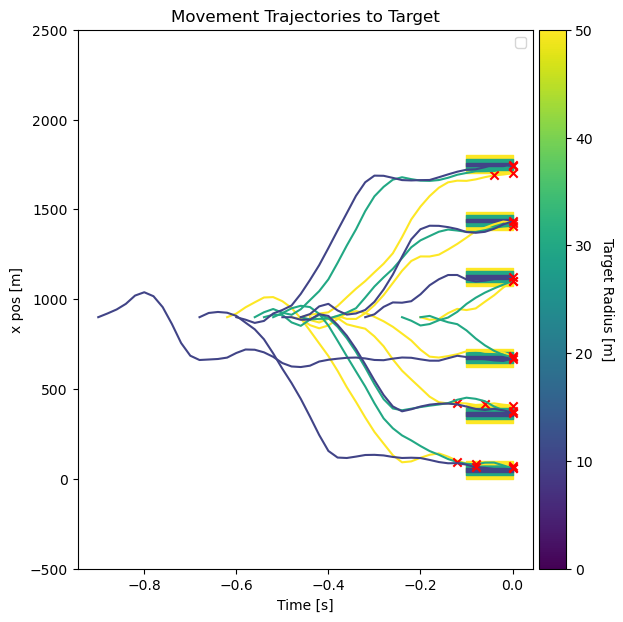

In [ ]:
import matplotlib.cm as cm

# Plot all trials in one plot
rows = [['Click', 'Click']]
fig, ax =  plt.subplot_mosaic(rows, figsize=(7, 7))

r_max = bounds[2][1]
plotreps = 10
zorder = 0

for i in range(len(targets)):
    # plot target as ribbon with alpha 0.3
    target_radius = targets[i][1]*1000
    target_x = targets[i][0]*1000
    color = cm.viridis(target_radius / r_max)
    if i == 0:
        ax['Click'].fill_between([-0.1, 0], target_x - target_radius, target_x + target_radius, alpha=1, color=color, zorder=zorder)
    else:
        ax['Click'].fill_between([-0.1, 0], target_x - target_radius, target_x + target_radius, alpha=1, color=color, zorder=zorder)
    zorder += 1

for (targetid, i) in complete_data.keys():
    # Skip if targetid is not in plottargets
    if (targetid, i) not in trialdata[['targetid', 'rep']].values:
        print(f"Skipping targetid {targetid}, rep {i} as it is not in trialdata.")
        continue

    # Extract data for the current setting
    data = complete_data[(targetid, i)]
    xx = data['xx']
    oo = data['oo']
    bb = data['bb']
    aa = data['aa']
    aa_applied = data['aa_applied']
    lll = data['lll']
    llr = data['llr']
    nefess = data['nefess']
    pragmatics = data['pragmatics']
    info_gains = data['info_gains']
    nefe_plan = data['nefe_plan']
    pragmatic_plan = data['pragmatic_plan']
    info_gain_plan = data['info_gain_plan']
    C_index = data['C_index']
    C = data['C']
    params = data['params']
    sys_params_real = data['sys_params_real']
    noise_params_real = data['noise_params_real']
    noise_params_model = data['noise_params_model']
    buttons = data['buttons']
    dt = data['dt']

    t = np.arange(-len(aa)*dt-1e-6,0,dt)
    
    # color by ID
    target_radius = targets[targetid][1]*1000
    color = cm.viridis(target_radius / r_max)
    if i == 0:
        ax['Click'].plot(t, [x[0]* 1000 +900 for x in xx], alpha=1, color=color, zorder=zorder)
    else:
        ax['Click'].plot(t, [x[0]* 1000 +900 for x in xx],  alpha=1, color=color, zorder=zorder)

    zorder += 1

    for j,o in enumerate(oo):
        if o[3] > 0.9:
            if j == 0 and targetid == 0:
                ax['Click'].scatter(t[j+1], xx[j+1][0]* 1000 +900, color='red', alpha=1, marker='x', label='Click', zorder=zorder)
            else:
                ax['Click'].scatter(t[j+1], xx[j+1][0]* 1000 +900, color='red', alpha=1, marker='x', zorder=zorder)

    zorder += 1

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=r_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax['Click'], pad=0.01)
cbar.set_label('Target Radius [m]', rotation=270, labelpad=15)
cbar.ax.tick_params(labelsize=10)

ax['Click'].set_xlabel('Time [s]')
ax['Click'].set_ylabel('x pos [m]')
ax['Click'].set_title('Movement Trajectories to Target')
ax['Click'].legend()

ax['Click'].set_ylim(-500, 2500)

In [19]:
# Save the figure as pdf
if not os.path.exists(f'{output_path}'):
    os.makedirs(f'{output_path}')
fig.savefig(f'{output_path}/cursor_trajectories.pdf', bbox_inches='tight')

### All Trajectories Width

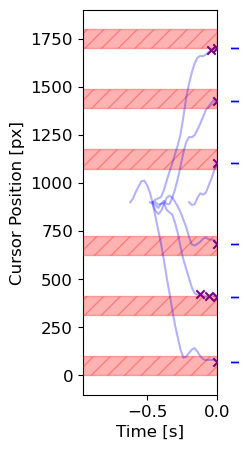

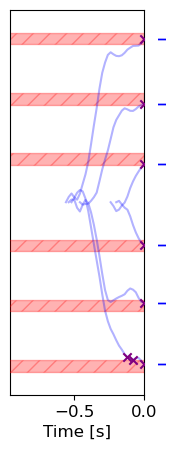

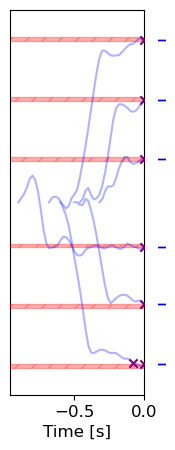

In [ ]:
for w_plot in [50, 30, 10]:

    # Error bar info
    if w_plot == 10:
        plot_targets = [12,13,14,15,16,17]
    elif w_plot == 30:
        plot_targets = [6,7,8,9,10,11]
    elif w_plot == 50:
        plot_targets = [0,1,2,3,4,5]

    endpoint_means_plot = [endpoint_means_sim[targetid] for targetid in plot_targets]
    endpoint_stds_plot = [endpoint_stds_sim[targetid] for targetid in plot_targets]

    # Plot all trials in one plot
    rows = [['Click', 'Error']]
    fig, ax =  plt.subplot_mosaic(rows, figsize=(2, 5), width_ratios=[1, 0.05])

    r_max = bounds[2][1]
    plotreps = 10
    zorder = 0

    for i in range(len(targets)):
        # plot target as ribbon with alpha 0.3
        target_radius = targets[i][1]*1000
        if target_radius != w_plot:
            continue
        target_x = targets[i][0]*1000
        color = cm.viridis(target_radius / r_max)
        if i == 0:
            ax['Click'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.3, color="red", zorder=zorder, hatch='//')
        else:
            ax['Click'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.3, color="red", zorder=zorder, hatch='//')
        zorder += 1

            
    for (targetid, i) in complete_data.keys():
        # Skip if targetid is not in plottargets
        if (targetid, i) not in trialdata[['targetid', 'rep']].values:
            print(f"Skipping targetid {targetid}, rep {i} as it is not in trialdata.")
            continue

        # Extract data for the current setting
        data = complete_data[(targetid, i)]
        xx = data['xx']
        oo = data['oo']
        bb = data['bb']
        aa = data['aa']
        aa_applied = data['aa_applied']
        lll = data['lll']
        llr = data['llr']
        nefess = data['nefess']
        pragmatics = data['pragmatics']
        info_gains = data['info_gains']
        nefe_plan = data['nefe_plan']
        pragmatic_plan = data['pragmatic_plan']
        info_gain_plan = data['info_gain_plan']
        C_index = data['C_index']
        C = data['C']
        params = data['params']
        sys_params_real = data['sys_params_real']
        noise_params_real = data['noise_params_real']
        noise_params_model = data['noise_params_model']
        buttons = data['buttons']
        dt = data['dt']

        t = np.arange(-len(aa)*dt-1e-6,0,dt)
        
        # color by ID
        target_radius = targets[targetid][1]*1000
        if target_radius != w_plot:
            continue
        color = cm.viridis(target_radius / r_max)
        if i == 0:
            ax['Click'].plot(t, [x[0]* 1000 +900 for x in xx], alpha=0.3, color="blue", zorder=zorder)
        else:
            ax['Click'].plot(t, [x[0]* 1000 +900 for x in xx],  alpha=0.3, color="blue", zorder=zorder)

        zorder += 1

        for j,o in enumerate(oo):
            if o[3] > 0.9:
                if j == 0 and targetid == 0:
                    ax['Click'].scatter(t[j+1], xx[j+1][0]* 1000 +900, color='purple', alpha=1, marker='x', label='Click', zorder=zorder)
                else:
                    ax['Click'].scatter(t[j+1], xx[j+1][0]* 1000 +900, color='purple', alpha=1, marker='x', zorder=zorder)

        zorder += 1

    ax['Click'].set_xlim(-max_time, 0.0)
    ax['Click'].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax['Click'].set_ylim(-100, 1900)
    
    ax['Click'].set_xlabel('Time [s]', fontsize=12)
    if w_plot == 50:
        ax['Click'].set_ylabel('Cursor Position [px]', fontsize=12)
    else:
        ax['Click'].set_ylabel(None)
        ax['Click'].set_yticks([])

    ax['Click'].tick_params(labelsize=12)

    # Error Bars - Plot the means with 95% confidence intervals
    ax['Error'].errorbar(
        x=np.zeros(len(endpoint_means_plot)),  # Use zeros for x-axis, as targets are categorical
        y=endpoint_means_plot, 
        yerr=endpoint_stds_plot, 
        capsize=5,
        linestyle='None',
        color='blue'
    )

    ax['Error'].set_ylim(-100, 1900)
    ax['Error'].axis('off')

    # Save the figure as pdf
    if not os.path.exists(f'{output_path}'):
        os.makedirs(f'{output_path}')
    fig.savefig(f'{output_path}/cursor_trajectories_w{w_plot}.pdf', bbox_inches='tight')

### Trajectories per ID

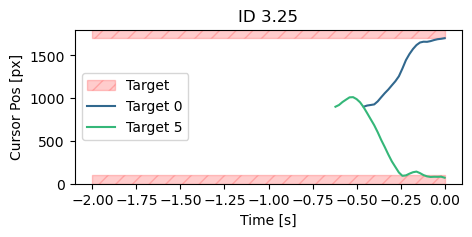

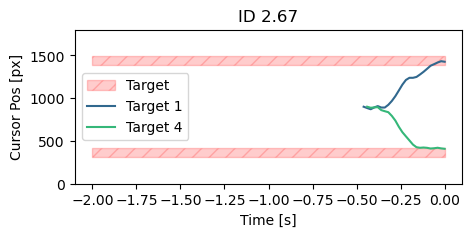

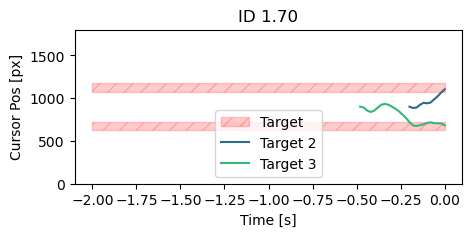

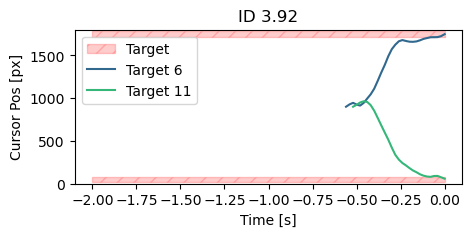

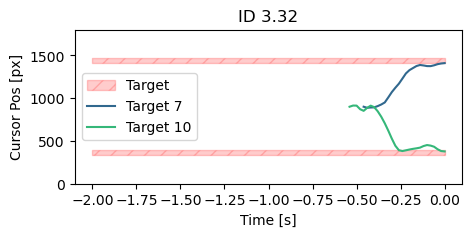

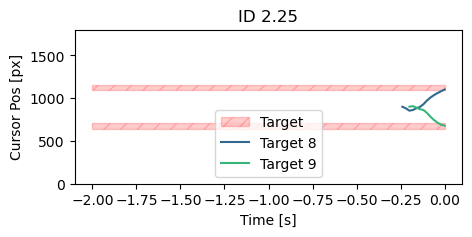

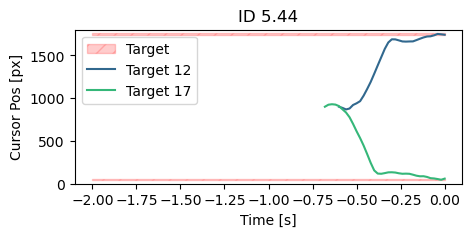

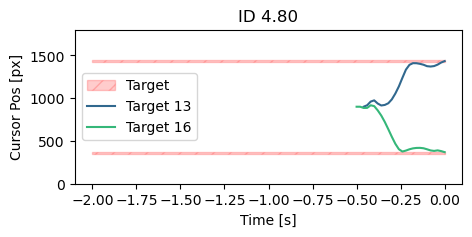

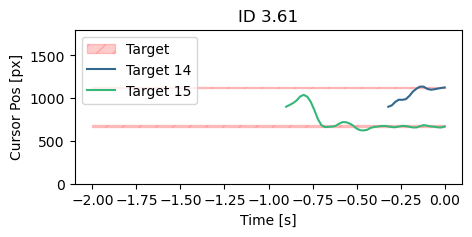

In [ ]:
# One plot per ID
for ID in unique_IDs:
    trial_data_indices = trialdata[trialdata['ID'] == ID].index.tolist()

    rows = [['Pos', 'Pos']]
    fig, ax =  plt.subplot_mosaic(rows, figsize=(5, 2))

    # Plot targets
    r_max = bounds[2][1]
    plotreps = 5
    zorder = 0
    labeled = False
    for targetid in trialdata.loc[trial_data_indices]['targetid'].unique():
        target_radius = targets[targetid][1]*1000
        target_x = targets[targetid][0]*1000
        color = 'red'
        if not labeled:
            ax['Pos'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.2, color=color, zorder=zorder, hatch='//', label=f'Target')
            labeled = True
        else:
            ax['Pos'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.2, color=color, zorder=zorder, hatch='//')
        zorder += 1

    colors = dict(zip(trialdata.loc[trial_data_indices]['targetid'].unique(), sns.color_palette("viridis", len(trialdata.loc[trial_data_indices]['targetid'].unique()))))

    target_labeled = dict([(targetid, False) for targetid in trialdata.loc[trial_data_indices]['targetid'].unique()])
    for (targetid, i) in trialdata.loc[trial_data_indices][['targetid', 'rep']].values:
        # Extract data for the current setting
        data = complete_data[(targetid, i)]
        xx = data['xx']
        oo = data['oo']
        bb = data['bb']
        aa = data['aa']
        aa_applied = data['aa_applied']
        lll = data['lll']
        llr = data['llr']
        nefess = data['nefess']
        pragmatics = data['pragmatics']
        info_gains = data['info_gains']
        nefe_plan = data['nefe_plan']
        pragmatic_plan = data['pragmatic_plan']
        info_gain_plan = data['info_gain_plan']
        C_index = data['C_index']
        C = data['C']
        params = data['params']
        sys_params_real = data['sys_params_real']
        noise_params_real = data['noise_params_real']
        noise_params_model = data['noise_params_model']
        buttons = data['buttons']
        dt = data['dt']

        t = np.arange(-len(aa)*dt-1e-6,0,dt)
        
        # color by ID
        target_radius = targets[targetid][1]*1000
        color = colors[targetid]
        if not target_labeled[targetid]:
            ax['Pos'].plot(t, [x[0]* 1000 +900 for x in xx], alpha=1, color=color, zorder=zorder, label=f'Target {targetid}')
            target_labeled[targetid] = True
        else:
            ax['Pos'].plot(t, [x[0]* 1000 +900 for x in xx],  alpha=1, color=color, zorder=zorder)

        zorder += 1

    ax['Pos'].set_xlabel('Time [s]')
    ax['Pos'].set_ylabel('Cursor Pos [px]')
    ax['Pos'].set_title(f'ID {ID:.2f}')
    ax['Pos'].legend()

    ax['Pos'].set_ylim(0, 1800)

    # Save the figure as pdf
    if not os.path.exists(f'{output_path}'):
        os.makedirs(f'{output_path}')
    fig.savefig(f'{output_path}/cursor_trajectories_ID_{ID:.2f}.pdf', bbox_inches='tight')

### Trajecories per ID vs User

In [22]:
_, trialdata_user, _, _, _, _, _ = load_from_json(user_data_path)


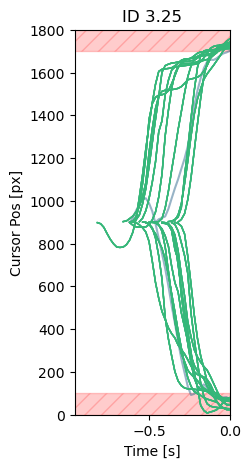

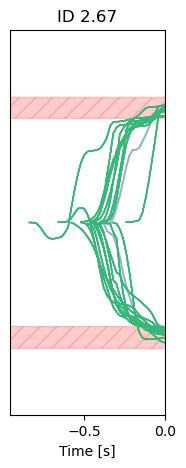

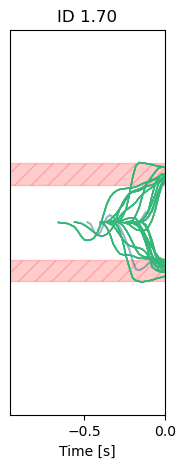

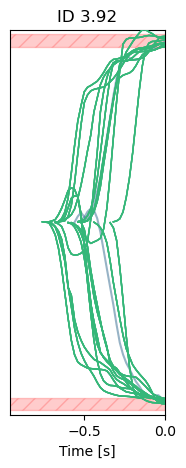

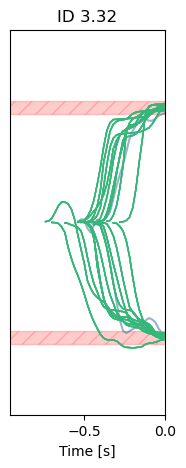

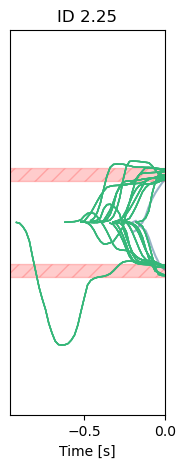

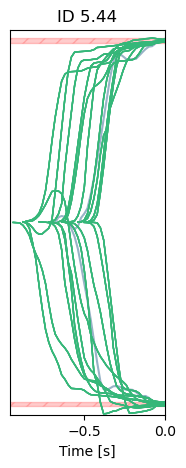

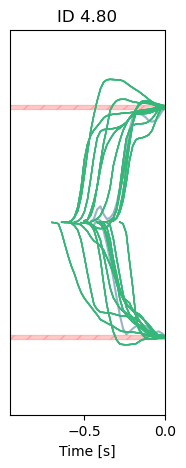

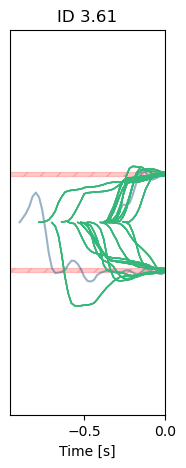

In [ ]:
# One plot per ID
y_labels_id = [unique_IDs.tolist()[0]]
colors = dict(zip(["sim", "user"], sns.color_palette("viridis", 2)))

for ID in unique_IDs:
    trial_data_indices = trialdata[trialdata['ID'] == ID].index.tolist()

    rows = [['Pos', 'Pos']]
    fig, ax =  plt.subplot_mosaic(rows, figsize=(2, 5))

    # Plot targets
    r_max = bounds[2][1]
    plotreps = 5
    zorder = 0
    labeled = False
    for targetid in trialdata.loc[trial_data_indices]['targetid'].unique():
        target_radius = targets[targetid][1]*1000
        target_x = targets[targetid][0]*1000
        color = 'red'
        if not labeled:
            ax['Pos'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.2, color=color, zorder=zorder, hatch='//', label=f'Target')
            labeled = True
        else:
            ax['Pos'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.2, color=color, zorder=zorder, hatch='//')
        zorder += 1

    target_labeled = dict([(targetid, False) for targetid in trialdata.loc[trial_data_indices]['targetid'].unique()])
    color = colors["sim"]
    for (targetid, i) in trialdata.loc[trial_data_indices][['targetid', 'rep']].values:
        # Extract data for the current setting
        data = complete_data[(targetid, i)]
        xx = data['xx']

        t = np.arange(-(len(xx)-1)*dt-1e-6,0,dt)
        
        # color by ID
        target_radius = targets[targetid][1]*1000
        if not target_labeled[targetid]:
            ax['Pos'].plot(t, [x[0]* 1000 +900 for x in xx], alpha=0.5, color=color, zorder=zorder, label=f'Sim {targetid}')
            target_labeled[targetid] = True
        else:
            ax['Pos'].plot(t, [x[0]* 1000 +900 for x in xx],  alpha=0.5, color=color, zorder=zorder)

        zorder += 1

    # User data
    target_labeled = dict([(targetid, False) for targetid in trialdata_user[trialdata_user['ID'] == ID]['target_id']])
    color = colors["user"]
    for targetid in trialdata_user[trialdata_user['ID'] == ID]['target_id']:
        repids = [j for (i, j) in user_pos.keys() if i == targetid]
        for i in repids:
            user_pos_plot = user_pos[(targetid, i)]
            t = np.arange(-(len(user_pos_plot)-1)*dt-1e-6,0,dt)
            
            if not target_labeled[targetid]:
                ax['Pos'].plot(t, user_pos_plot, alpha=0.5, color=color, linewidth=1.0, zorder=zorder, label=f'User {targetid}')
                target_labeled[targetid] = True
            else:
                ax['Pos'].plot(t, user_pos_plot,  alpha=0.5, color=color, linewidth=1.0, zorder=zorder)

            zorder += 1

    ax['Pos'].set_xlabel('Time [s]')
    if ID in y_labels_id:
        ax['Pos'].set_ylabel('Cursor Pos [px]')
    else:
        # remove y ticks
        ax['Pos'].set_yticks([])
    ax['Pos'].set_title(f'ID {ID:.2f}')

    ax['Pos'].set_xlim(-max_time, 0.0)
    ax['Pos'].set_ylim(0, 1800)

    # Save the figure as pdf
    if not os.path.exists(f'{output_path}'):
        os.makedirs(f'{output_path}')
    fig.savefig(f'{output_path}/cursor_trajectories_vs_user_ID_{ID:.2f}.pdf', bbox_inches='tight')

## All trajectory Width plots User

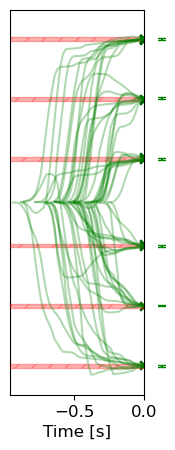

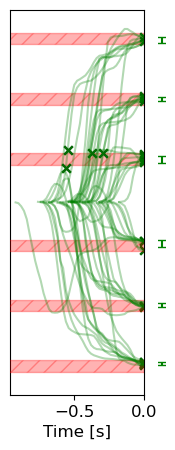

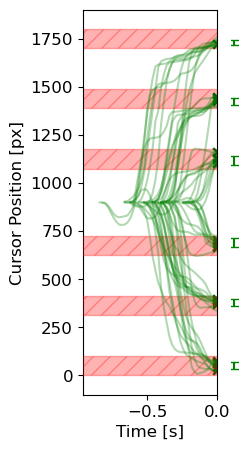

In [24]:
for w_plot in [10, 30, 50]:

    ## Error bar info
    if w_plot == 10:
        plot_targets = [12,13,14,15,16,17]# [0,1,2] #
    elif w_plot == 30:
        plot_targets = [6,7,8,9,10,11]
    elif w_plot == 50:
        plot_targets = [0,1,2,3,4,5]

    endpoint_means_plot = [endpoint_means_user[targetid] for targetid in plot_targets]
    endpoint_stds_plot = [endpoint_stds_user[targetid] for targetid in plot_targets]

    # Plot all trials in one plot
    rows = [['Click', 'Error']]#, ['Click x', 'Click y']
    fig, ax =  plt.subplot_mosaic(rows, figsize=(2, 5), width_ratios=[1, 0.05])

    r_max = bounds[2][1]
    plotreps = 10
    zorder = 0

    for i in range(len(targets)):
        # plot target as ribbon with alpha 0.3
        target_radius = targets[i][1]*1000
        if target_radius != w_plot:
            continue
        target_x = targets[i][0]*1000
        color = cm.viridis(target_radius / r_max)
        if i == 0:
            ax['Click'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.3, color="red", zorder=zorder, hatch='//')
        else:
            ax['Click'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.3, color="red", zorder=zorder, hatch='//')
        

        zorder += 1


    for (targetid, i) in user_pos.keys():

        pos = user_pos[(targetid, i)]

        t = np.arange(-(len(pos)-1)*dt-1e-6,0,dt)
        
        # color by ID

        target_radius = targets[targetid][1]*1000
        if target_radius != w_plot:
            continue
        color = cm.viridis(target_radius / r_max)
        if i == 0:
            ax['Click'].plot(t, pos, alpha=0.3, color="green", zorder=zorder) # label=f'Mouse Movement {i}',
        else:
            ax['Click'].plot(t, pos,  alpha=0.3, color="green", zorder=zorder) #color=color,

        zorder += 1

        # Click
        for i in range(len(clicks_complete[targetid])):
            # plot cross at each click
            if i == 0:
                ax['Click'].scatter(clicks_complete[targetid][i]['t'], clicks_complete[targetid][i]['x'], color='darkgreen', alpha=0.3, marker='x', label='Click', zorder=2)
            else:
                ax['Click'].scatter(clicks_complete[targetid][i]['t'], clicks_complete[targetid][i]['x'], color='darkgreen', alpha=0.3, marker='x', zorder=2)

        zorder += 1


    ax['Click'].set_xlim(-max_time, 0.0)
    ax['Click'].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax['Click'].set_ylim(-100, 1900)
    
    ax['Click'].set_xlabel('Time [s]', fontsize=12)
    if w_plot == 50:
        ax['Click'].set_ylabel('Cursor Position [px]', fontsize=12)
    else:
        ax['Click'].set_ylabel(None)
        ax['Click'].set_yticks([])

    ax['Click'].tick_params(labelsize=12)

    ## Error Bars
        # Plot the means with 95% confidence intervals
    ax['Error'].errorbar(
        x=np.zeros(len(endpoint_means_plot)),  # Use zeros for x-axis, as targets are categorical
        y=endpoint_means_plot,
        yerr=endpoint_stds_plot,
        capsize=5,
        linestyle="none",
        color='green'
    )

    ax['Error'].set_ylim(-100, 1900)
    ax['Error'].axis('off')

    # Save the figure as pdf
    if not os.path.exists(f'{output_path}'):
        os.makedirs(f'{output_path}')
    fig.savefig(f'{output_path}/cursor_trajectories_{user_name}_w{w_plot}.pdf', bbox_inches='tight')

# User Intro Plots

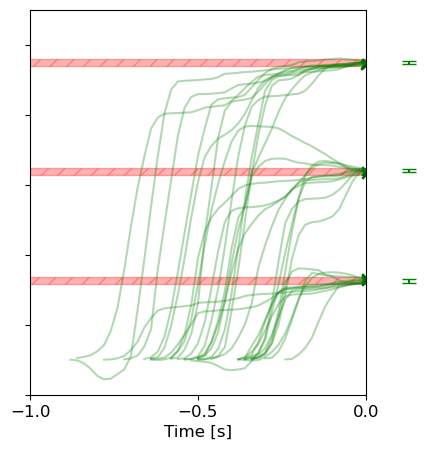

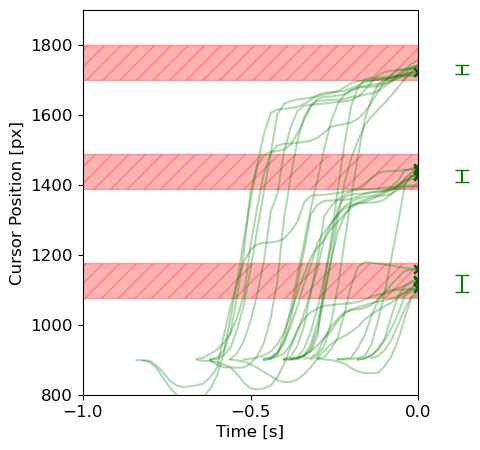

In [ ]:
for w_plot in [10, 50]:

    # Error bar info
    if w_plot == 10:
        plot_targets = [12,13,14]
    elif w_plot == 30:
        plot_targets = [6,7,8]
    elif w_plot == 50:
        plot_targets = [0,1,2]

    endpoint_means_plot = [endpoint_means_user[targetid] for targetid in plot_targets]
    endpoint_stds_plot = [endpoint_stds_user[targetid] for targetid in plot_targets]

    # Plot all trials in one plot
    rows = [['Click', 'Error']]
    fig, ax =  plt.subplot_mosaic(rows, figsize=(5, 5), width_ratios=[1, 0.05])

    r_max = bounds[2][1]
    plotreps = 10
    zorder = 0

    for i in plot_targets:
        # plot target as ribbon with alpha 0.3
        target_radius = targets[i][1]*1000
        target_x = targets[i][0]*1000
        color = cm.viridis(target_radius / r_max)
        if i == 0:
            ax['Click'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.3, color="red", zorder=zorder, hatch='//')
        else:
            ax['Click'].fill_between([-2, 0], target_x - target_radius, target_x + target_radius, alpha=0.3, color="red", zorder=zorder, hatch='//')
        
        zorder += 1

    for (targetid, i) in user_pos.keys():
        if targetid not in plot_targets:
            continue

        pos = user_pos[(targetid, i)]

        t = np.arange(-(len(pos)-1)*dt-1e-6,0,dt)
        
        # color by ID
        target_radius = targets[targetid][1]*1000
        if target_radius != w_plot:
            continue
        color = cm.viridis(target_radius / r_max)
        if i == 0:
            ax['Click'].plot(t, pos, alpha=0.3, color="green", zorder=zorder)
        else:
            ax['Click'].plot(t, pos,  alpha=0.3, color="green", zorder=zorder)

        zorder += 1

        # Click
        for i in range(len(clicks_complete[targetid])):
            # plot cross at each click
            if i == 0:
                ax['Click'].scatter(clicks_complete[targetid][i]['t'], clicks_complete[targetid][i]['x'], color='darkgreen', alpha=0.3, marker='x', label='Click', zorder=2)
            else:
                ax['Click'].scatter(clicks_complete[targetid][i]['t'], clicks_complete[targetid][i]['x'], color='darkgreen', alpha=0.3, marker='x', zorder=2)

        zorder += 1

    ax['Click'].set_xlim(-1.0, 0.0)
    ax['Click'].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax['Click'].set_ylim(800, 1900)
    
    ax['Click'].set_xlabel('Time [s]', fontsize=12)
    if w_plot == 50:
        ax['Click'].set_ylabel('Cursor Position [px]', fontsize=12)
    else:
        ax['Click'].set_ylabel(None)
        ax['Click'].set_yticklabels([])

    ax['Click'].tick_params(labelsize=12)

    # Error Bars - Plot the means with 95% confidence intervals
    ax['Error'].errorbar(
        x=np.zeros(len(endpoint_means_plot)),  # Use zeros for x-axis, as targets are categorical
        y=endpoint_means_plot,
        yerr=endpoint_stds_plot,
        capsize=5,
        linestyle="none",
        color='green'
    )

    ax['Error'].set_ylim(800, 1900)
    ax['Error'].axis('off')

    # Save the figure as pdf
    if not os.path.exists(f'{output_path}'):
        os.makedirs(f'{output_path}')
    fig.savefig(f'{output_path}/intro_cursor_trajectories_{user_name}_w{w_plot}.pdf', bbox_inches='tight')

# Fitts' Law Plots

### Simulation

/tmp/ipykernel_121180/827110521.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="ID", y="movement_time", data=trialdata, ax=ax, palette="deep")


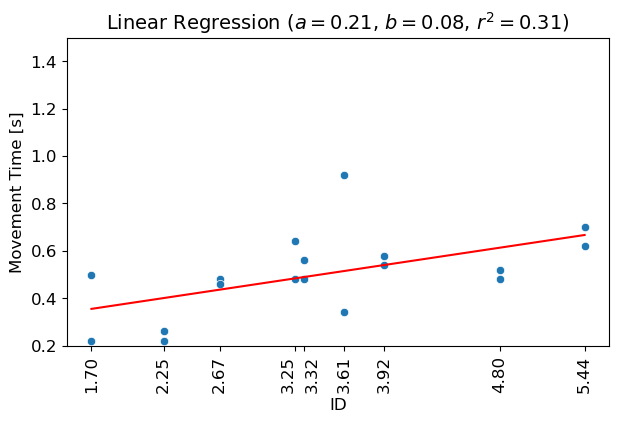

In [26]:

fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(x="ID", y="movement_time", data=trialdata, ax=ax, palette="deep")
# Set xticks to ID
ax.set_xticks(trialdata["ID"].unique())
# reduce x ticks precision to 2 decimal places
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
# Rotate all x-tick labels 90 degrees
for label in ax.get_xticklabels():
    text = label.get_text()
    label.set_rotation(90)
    
    if text == '3.25':
        label.set_ha('right')
        label.set_x(label.get_position()[0] - 0.05)  # Nudge left
    elif text == '3.32':
        label.set_ha('left')
        label.set_x(label.get_position()[0] + 0.05)  # Nudge right
    else:
        label.set_ha('center')



from scipy.optimize import curve_fit
def fitts_law(ID, a, b):
    return a + b * ID


# Fit the data to the Fitts Law equation
popt, pcov = curve_fit(fitts_law, trialdata["ID"], trialdata["movement_time"])
a_sim, b_sim = popt

# Calculate the goodness of fit
from sklearn.metrics import r2_score
fitted_values = []
movement_times_total = []
for i, time in enumerate(trialdata["movement_time"]):
    fitted_values.append(fitts_law(trialdata.iloc[i]["ID"], a_sim, b_sim))
r2_sim = r2_score(trialdata["movement_time"], fitted_values)


ids = np.linspace(trialdata["ID"].min(), trialdata["ID"].max(), 10)
# Calculate the fitted values
fitted_values = fitts_law(np.array(ids), a_sim, b_sim)
# Plot the data and the fitted line
ax.plot(ids, fitted_values, label='Linear Regression', color='red')
ax.set_xlabel('ID', fontsize=12)
ax.set_ylabel('Movement Time [s]', fontsize=12)
ax.set_title(f'Linear Regression ($a={a_sim:.2f}$, $b={b_sim:.2f}$, $r^2={r2_sim:.2f}$)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim((0.2, 1.5))

plt.show()




In [27]:
fig.savefig(f'{output_path}/fitts_law_fit_simulation.pdf', bbox_inches='tight')

### User

/tmp/ipykernel_121180/3759208346.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="ID", y="movement_time", data=trialdata_user, ax=ax, palette="deep")


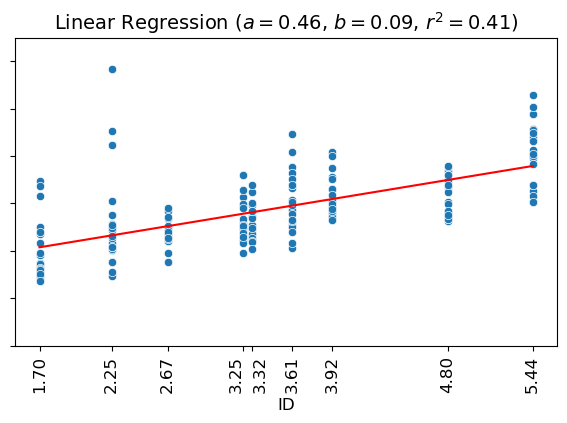

In [28]:

fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(x="ID", y="movement_time", data=trialdata_user, ax=ax, palette="deep")
# Set xticks to ID
ax.set_xticks(trialdata_user["ID"].unique())
ax.set_xticklabels(trialdata_user["ID"].unique(), rotation=45, ha='right')
# reduce x ticks precision to 2 decimal places
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
# Rotate all x-tick labels 90 degrees
for label in ax.get_xticklabels():
    text = label.get_text()
    label.set_rotation(90)
    
    if text == '3.25':
        label.set_ha('right')
        label.set_x(label.get_position()[0] - 0.05)  # Nudge left
    elif text == '3.32':
        label.set_ha('left')
        label.set_x(label.get_position()[0] + 0.05)  # Nudge right
    else:
        label.set_ha('center')

# Fit the data to the Fitts Law equation
popt, pcov = curve_fit(fitts_law, trialdata_user["ID"], trialdata_user["movement_time"])
a_user, b_user = popt

# Calculate the goodness of fit
fitted_values = []
movement_times_total = []
for i, time in enumerate(trialdata_user["movement_time"]):
    fitted_values.append(fitts_law(trialdata_user.iloc[i]["ID"], a_user, b_user))
r2_user = r2_score(trialdata_user["movement_time"], fitted_values)

ids = np.linspace(trialdata_user["ID"].min(), trialdata_user["ID"].max(), 10)
# Calculate the fitted values
fitted_values = fitts_law(np.array(ids), a_user, b_user)
# Plot the data and the fitted line
ax.plot(ids, fitted_values, label='Linear Regression', color='red')
ax.set_xlabel('ID', fontsize=12)
ax.set_ylabel('Movement Time [s]', fontsize=12)
ax.set_title(f'Linear Regression ($a={a_user:.2f}$, $b={b_user:.2f}$, $r^2={r2_user:.2f}$)', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim((0.2, 1.5))

# plt.yticks([])
ax.get_yaxis().set_ticklabels([])
ax.set_ylabel(None)
plt.show()




In [29]:
fig.savefig(f'{output_path}/fitts_law_fit_user.pdf', bbox_inches='tight')

# Single Trajectory Plot

In [30]:
# Select targetid and rep to plot
targetid = 0
rep = 0

# Extract data for the current setting
data = complete_data[(targetid, rep)]   
xx = data['xx']
oo = data['oo']
bb = data['bb']
aa = data['aa']
aa_applied = data['aa_applied']
lll = data['lll']
llr = data['llr']
nefess = data['nefess']
pragmatics = data['pragmatics']
info_gains = data['info_gains']
nefe_plan = data['nefe_plan']
pragmatic_plan = data['pragmatic_plan']
info_gain_plan = data['info_gain_plan']
buttons = data['buttons']
bb_after_rt = data['bb_after_rt']


xx = [x.at[0].set(x[0] * 1000+900) for x in xx]
oo = [o.at[0].set(o[0] * 1000+900) for o in oo]
bb_new = []
bb_after_rt_new = []
for b in bb:
    b_new = [b[0].at[0].set(b[0][0] * 1000+900), b[1].at[0,0].set(b[1][0,0]* 1000**2)]
    bb_new.append(b_new)
for b in bb_after_rt:
    bb_after_rt_new.append([b[0].at[0].set(b[0][0] * 1000+900), b[1].at[0,0].set(b[1][0,0]* 1000**2)])

bb = bb_new
bb_after_rt = bb_after_rt_new
buttons = [np.array([b[0]*1000+900,b[1]*1000]) for b in buttons]

plot_axes = ['pos', 'finger']


Rows: [['pos', 'pos'], ['finger', 'finger']]


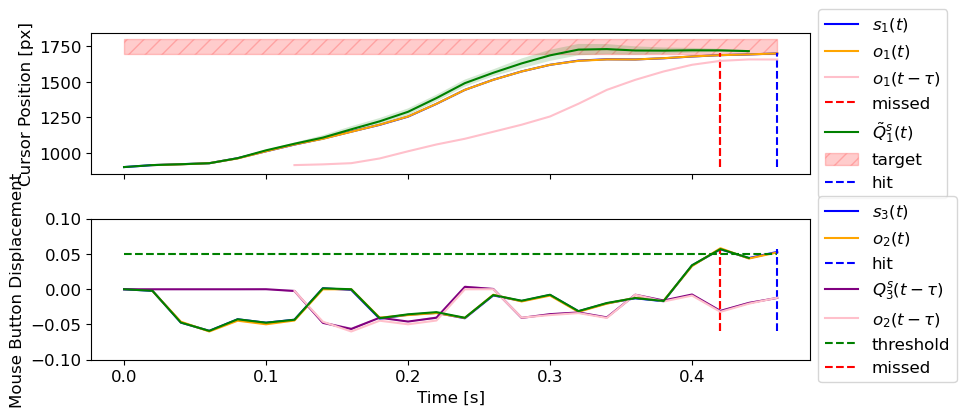

In [31]:
fig, ax = plt.subplot_mosaic([[plot_axes[0],plot_axes[0]],[plot_axes[1],plot_axes[1]]], figsize=(10, 4), sharex=True)

fig, ax, t, clicks, button_switch = plot_results(dt, xx, oo, bb, aa, aa_applied, lll, llr, nefe_plan, pragmatic_plan, info_gain_plan, nefess, pragmatics, info_gains, buttons=[buttons[1]], belief_button=False, click_state=True, additional_obs=True, obs_missclick=True, plot_axes=plot_axes, distance_unit="px", fig=fig, ax=ax)


reaction_time_steps = 5
std_mult = 3
ax['pos'].plot(t[reaction_time_steps+1:], [o[0] for o in oo[:-reaction_time_steps]], label=['$o_1(t-\\tau)$'], color = "pink")
mean = [b[0][0] for b in bb_after_rt]
var = [b[1][0, 0] for b in bb_after_rt]
ax['pos'].plot(t[:-1], mean, label=['$\\tilde{Q}^s_1(t)$'], color='green')
ribbons = np.array([[mean[i] - std_mult * np.sqrt(var[i]), mean[i] + std_mult * np.sqrt(var[i])] for i in range(len(mean))])
ax['pos'].fill_between(t[:-1], ribbons[:, 0], ribbons[:, 1], facecolor="green", alpha=1 / 6)
ax['pos'].legend()

ax['pos'].set_xlabel(None)

ax['finger'].plot(t[reaction_time_steps+1:], [o[1] for o in oo[:-reaction_time_steps]], label=['$o_2(t-\\tau)$'], color = "pink")
mean = [b[0][3] for b in bb_after_rt]
var = [b[1][3, 3] for b in bb_after_rt]
ax['finger'].plot(t[:-1], mean, label=['$\\tilde{Q}^s_3(t)$'], color='green')
ribbons = np.array([[mean[i] - std_mult * np.sqrt(var[i]), mean[i] + std_mult * np.sqrt(var[i])] for i in range(len(mean))])
ax['finger'].fill_between(t[:-1], ribbons[:, 0], ribbons[:, 1], facecolor="green", alpha=1 / 6)
ax['finger'].legend()

# increase label size
ax['pos'].tick_params(labelsize=12)
ax['finger'].tick_params(labelsize=12)
ax['finger'].set_xlabel(ax['finger'].get_xlabel(), fontsize=12)
ax['pos'].set_ylabel(ax['pos'].get_ylabel(),fontsize=12)
ax['finger'].set_ylabel(ax['finger'].get_ylabel(),fontsize=12)

# change legend font size
move_legend_out(ax['pos'], fontsize=12, order = [1,2,5,3,6,0,4])
move_legend_out(ax['finger'], fontsize=12, order = [0,1,5,2,6,3,4])

In [32]:
# Save the figure as pdf
if not os.path.exists(f'{output_path}'):
    os.makedirs(f'{output_path}')

fig.savefig(f'{output_path}/cursor_trajectories_targetid_{targetid}_rep_{rep}.pdf', bbox_inches='tight')

## Slim

Rows: [['pos', 'pos']]


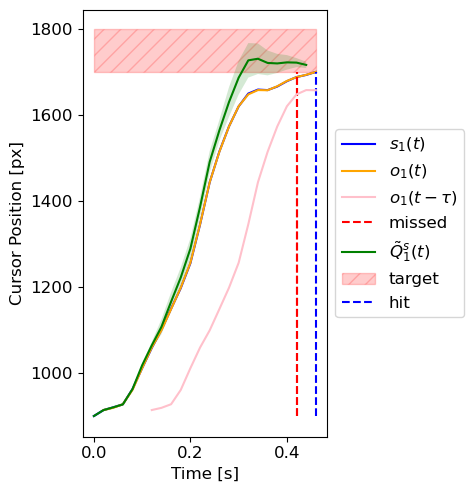

In [33]:
plot_axes = ['pos']
fig, ax = plt.subplot_mosaic([[plot_axes[0],plot_axes[0]]], figsize=(4, 5), sharex=True)

fig, ax, t, clicks, button_switch = plot_results(dt, xx, oo, bb, aa, aa_applied, lll, llr, nefe_plan, pragmatic_plan, info_gain_plan, nefess, pragmatics, info_gains, buttons=[buttons[1]], belief_button=False, click_state=True, additional_obs=True, obs_missclick=True, plot_axes=plot_axes, distance_unit="px", fig=fig, ax=ax)


reaction_time_steps = 5
# ax['pos'].set_ylim([-0.2, 1.0])
std_mult = 3
ax['pos'].plot(t[reaction_time_steps+1:], [o[0] for o in oo[:-reaction_time_steps]], label=['$o_1(t-\\tau)$'], color = "pink")
mean = [b[0][0] for b in bb_after_rt]
var = [b[1][0, 0] for b in bb_after_rt]
ax['pos'].plot(t[:-1], mean, label=['$\\tilde{Q}^s_1(t)$'], color='green')
ribbons = np.array([[mean[i] - std_mult * np.sqrt(var[i]), mean[i] + std_mult * np.sqrt(var[i])] for i in range(len(mean))])
ax['pos'].fill_between(t[:-1], ribbons[:, 0], ribbons[:, 1], facecolor="green", alpha=1 / 6)
ax['pos'].legend()

# increase label size
ax['pos'].tick_params(labelsize=12)
ax['pos'].set_xlabel(ax['pos'].get_xlabel(), fontsize=12)
ax['pos'].set_ylabel(ax['pos'].get_ylabel(),fontsize=12)

# change legend font size
move_legend_out(ax['pos'], fontsize=12, order = [1,2,5,3,6,0,4])

In [35]:
# Save the figure as pdf
if not os.path.exists(f'{output_path}'):
    os.makedirs(f'{output_path}')

fig.savefig(f'{output_path}/cursor_pos_slim_targetid_{targetid}_rep_{rep}.pdf', bbox_inches='tight')

Rows: [['finger', 'finger']]


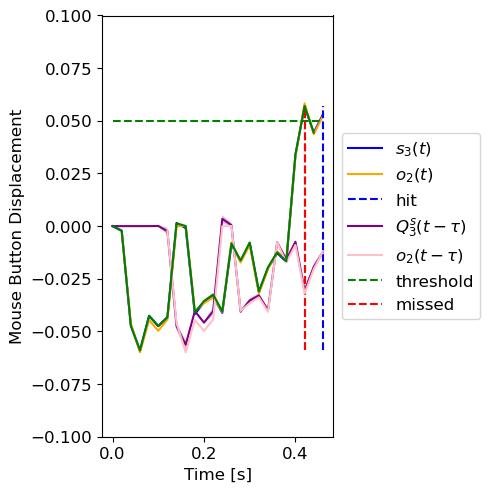

In [ ]:
plot_axes = ['finger']
fig, ax = plt.subplot_mosaic([[plot_axes[0],plot_axes[0]]], figsize=(4, 5), sharex=True)

fig, ax, t, clicks, button_switch = plot_results(dt, xx, oo, bb, aa, aa_applied, lll, llr, nefe_plan, pragmatic_plan, info_gain_plan, nefess, pragmatics, info_gains, buttons=[buttons[1]], belief_button=False, click_state=True, additional_obs=True, obs_missclick=True, plot_axes=plot_axes, distance_unit="px", fig=fig, ax=ax)

reaction_time_steps = 5
std_mult = 3

ax['finger'].plot(t[reaction_time_steps+1:], [o[1] for o in oo[:-reaction_time_steps]], label=['$o_2(t-\\tau)$'], color = "pink")
mean = [b[0][3] for b in bb_after_rt]
var = [b[1][3, 3] for b in bb_after_rt]
ax['finger'].plot(t[:-1], mean, label=['$\\tilde{Q}^s_3(t)$'], color='green')
ribbons = np.array([[mean[i] - std_mult * np.sqrt(var[i]), mean[i] + std_mult * np.sqrt(var[i])] for i in range(len(mean))])
ax['finger'].fill_between(t[:-1], ribbons[:, 0], ribbons[:, 1], facecolor="green", alpha=1 / 6)
ax['finger'].legend()

# increase label size
ax['finger'].tick_params(labelsize=12)
ax['finger'].set_xlabel(ax['finger'].get_xlabel(), fontsize=12)
ax['finger'].set_ylabel(ax['finger'].get_ylabel(),fontsize=12)

# change legend order and change legend font size
move_legend_out(ax['finger'], fontsize=12, order = [0,1,5,2,6,3,4])

In [36]:
# Save the figure as pdf
if not os.path.exists(f'{output_path}'):
    os.makedirs(f'{output_path}')

fig.savefig(f'{output_path}/finger_slim_targetid_{targetid}_rep_{rep}.pdf', bbox_inches='tight')